In [1]:
%env JAX_PLATFORMS=cpu
%env JAX_ENABLE_X64=True

env: JAX_PLATFORMS=cpu
env: JAX_ENABLE_X64=True


In [2]:
import jax.numpy as jnp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from concept import (
    plot_current,
    plot_gradients,
    plot_spikes,
    plot_spiketimes,
    plot_voltage,
    vary_t,
    vary_w,
)
from spikegd.lif import LIFNeuron
from spikegd.qif import QIFNeuron
from spikegd.utils.plotting import (
    cm2inch,
    cmap_purples,
    panel_label,
)

In [3]:
plt.style.use("spikegd.utils.plotstyle")

# Run experiments

## QIF

In [4]:
config_qif = {
    # Neuron
    "tau": 1.0,
    "eps": 1e-6,
    # Trial
    "T": 4.0,
    "K": 4,  # Maximal number of simulated ordinary spikes
    "dt": 0.01,  # Step size used to compute state traces
}

qif = QIFNeuron(config_qif["tau"], config_qif["eps"])

In [5]:
grid_w_qif, examples_w_qif = vary_w(qif, jnp.array([0.95, 1.15, 1.5]), config_qif)

In [6]:
grid_t_qif, examples_t_qif = vary_t(
    qif, jnp.array([0.5, 0.62, 1.4]), config_qif, w_exc_relative=1.5
)

## cLIF

In [7]:
config_lif = {
    # Neuron
    "tau": 1.0,
    "V_th": 1.0,
    # Trial
    "T": 3.0,
    "K": 5,
    "dt": 0.01,
}

lif = LIFNeuron(config_lif["tau"], config_lif["V_th"])

In [8]:
grid_w_lif, examples_w_lif = vary_w(
    lif, jnp.array([0.95, 1.15, 1.4]), config_lif, Nvar=500_000
)

In [9]:
grid_t_lif, examples_t_lif = vary_t(
    lif, jnp.array([0.8, 1.5, 3.0]), config_lif, w_exc_relative=1.4, Nvar=500_000
)

# Plot results

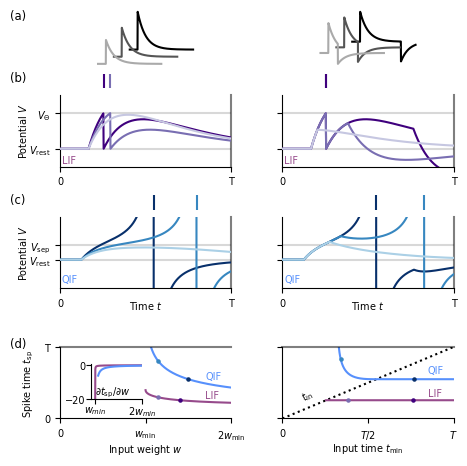

In [10]:
### Figure
fig = plt.figure(figsize=cm2inch(1.5 * 8.6, 1.5 * 9))
ratio = 2.5
space = 0.75
height_ratios = [ratio - 0.5, 1, ratio, space, 1, ratio, space + 1.3, ratio]
gs = gridspec.GridSpec(
    8,
    2,
    figure=fig,
    hspace=0.0,
    wspace=0.3,
    height_ratios=height_ratios,
)

### Scheme
ax = fig.add_subplot(gs[0, 0])
plot_current(ax, examples_w_qif)
panel_label(fig, ax, "(a)", x=-0.5, y=-0.1)
ax = fig.add_subplot(gs[0, 1])
plot_current(ax, examples_t_qif)

### Examples LIF
ax = fig.add_subplot(gs[1, 0])
plot_spikes(ax, examples_w_lif, config_lif, cmap_purples)
panel_label(fig, ax, "(b)", x=-0.5, y=-0.15)
ax = fig.add_subplot(gs[1, 1])
plot_spikes(ax, examples_t_lif, config_lif, cmap_purples)
ax = fig.add_subplot(gs[2, 0])
plot_voltage(ax, examples_w_lif, config_lif, cmap_purples, "LIF")
ax.set_ylabel("Potential $V$", labelpad=0)
ax = fig.add_subplot(gs[2, 1])
plot_voltage(ax, examples_t_lif, config_lif, cmap_purples, "LIF")
ax.tick_params(labelleft=False)

### Examples QIF
ax = fig.add_subplot(gs[4, 0])
plot_spikes(ax, examples_w_qif, config_qif)
panel_label(fig, ax, "(c)", x=-0.5, y=-0.15)
ax = fig.add_subplot(gs[4, 1])
plot_spikes(ax, examples_t_qif, config_qif)
ax = fig.add_subplot(gs[5, 0])
plot_voltage(ax, examples_w_qif, config_qif)
ax.set_ylabel("Potential $V$", labelpad=0)
ax.set_xlabel("Time $t$", labelpad=-6)
ax = fig.add_subplot(gs[5, 1])
plot_voltage(ax, examples_t_qif, config_qif)
ax.set_xlabel("Time $t$", labelpad=-6)
ax.tick_params(labelleft=False)

### Spike times

# Variable weight
ax = fig.add_subplot(gs[7, 0])
axref = ax
plot_spiketimes(ax, grid_w_qif, examples_w_qif, config_qif, "C0")
ax.text(0.85, 0.55, "QIF", color="C0")
plot_spiketimes(ax, grid_w_lif, examples_w_lif, config_lif, "C3", cmap_purples)
ax.text(0.85, 0.29, "LIF", color="C3")
ax.axhline(1, color="k", alpha=0.5, clip_on=False)
ax.set_xticklabels(["0", r"$w_{\mathrm{min}}$", r"$2w_{\mathrm{min}}$"])
ax.set_xlabel("Input weight $w$", labelpad=0)
ax.set_yticklabels(["0", "T"])
ax.set_ylabel(r"Spike time $t_{\mathrm{sp}}$", labelpad=6)
panel_label(fig, ax, "(d)", x=-0.5)

# Variable time
ax = fig.add_subplot(gs[7, 1])
plot_spiketimes(ax, grid_t_qif, examples_t_qif, config_qif, "C0")
ax.text(0.85, 0.63, "QIF", color="C0")
plot_spiketimes(ax, grid_t_lif, examples_t_lif, config_lif, "C3", cmap_purples)
ax.axhline(1, color="k", alpha=0.5, clip_on=False)
ax.text(0.85, 0.31, "LIF", color="C3")
ax.set_xticklabels(["0", "$T/2$", "$T$"])
ax.set_xlabel(r"Input time $t_{\mathrm{min}}$", labelpad=0)
ax.plot([0, 1], [0, 1], "k", ls=":", zorder=-1)
ax.text(0.1, 0.25, r"$t_{\mathrm{in}}$", rotation=30, color="k")
ax.tick_params(labelleft=False)


# Inset
ax = inset_axes(
    axref,
    width="100%",
    height="100%",
    bbox_to_anchor=(0.15, 0.2, 0.3, 0.5),
    bbox_transform=axref.transAxes,
    loc="lower left",
)
plot_gradients(ax, grid_w_lif, examples_w_lif, config_lif, "C3")
plot_gradients(ax, grid_w_qif, examples_w_qif, config_qif, "C0")
ax.text(0.5, -17, r"$\partial t_{\mathrm{sp}}/ \partial w$", color="k")
ax.tick_params(axis="both", which="major", pad=0)
ax.set_xlim(0.9 * 1 / 2, 1)
ax.set_xticks([1 / 2, 1], [r"$w_{min}$", r"$2w_{min}$"])
ax.set_ylim(-20, 1)

plt.show()